Predicción de gastos médicos usando regresión lineal
===

>[Predicción de gastos médicos usando regresión lineal](#scrollTo=CFRR25nUpMNZ)

>>[Descripción del problema](#scrollTo=tfLuS2EIpMNb)

>>[Lectura de datos](#scrollTo=EtoLk8dLpMNd)

>>[Especificación del modelo](#scrollTo=w30HyX-EpMNf)

>>[Estimación del modelo](#scrollTo=CKxdRWrCpMNg)

>>[Evaluación de error](#scrollTo=u2cTsm_ppMNh)

>>[Análisis independiente](#scrollTo=X38wNOVS3_bf)

>>>[Identificación de variables categóricas](#scrollTo=brc-flfA5kRR)

>>>[Correlaciones](#scrollTo=Tvflwl495-pl)

>>[Recursos de ayuda](#scrollTo=Zyyte4tw9RXf)



Descripción del problema
---

Una compañía de seguros desea pronósticar los gastos médicos de la población asegurada con el fin de recolectar un valor superior en ingresos, tal que le permita obtener utilidades. Los costos son difíciles de pronósticar ya que las condiciones más costosas son más raras y parecen aleatorias; y que ciertas condiciones son más probables para ciertos segmentos de la población (infarto en personas obesas y cáncer en fumadores).

El objetivo es usar una base de datos con 1338 registros de gastos médicos hipotéticos para pacientes de EU con el fin de estimar los costos para determinados segmentos de la población. La información registrada es la siguiente:

* **Age**: entero hasta 64.

* **Sex**: male, female.

* **bmi**: Body mass index.

* **children**: entero indicando la cantidad de hijos/dependientes cubiertos por el plan de salud.

* **smoker**: yes, no.

* **region**: northest, southeast, southwest, northwest.

* **charges**: costos.


Lectura de datos
--

In [ ]:
import pandas as pd

#
# Lectura del archivo y verificación
#
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/insurance.csv",
    sep=",",
    thousands=None,
    decimal=".",
)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Especificación del modelo
---

In [ ]:
# Para transformar columnas en un conjunto de datos
from sklearn.compose import ColumnTransformer, make_column_selector

# Para realizar la codificación one-hot de variables categoricas
from sklearn.preprocessing import OneHotEncoder

# Objeto para aplicar transformaciones a columnas específicas
columnTransformer = ColumnTransformer(

    # Lista de las transformaciones que se aplicarán a las columnas
    transformers=[
        (
            # Nombre para identificar la transformación
            "ohe",

            # Si una columna categórica tiene solo dos categorías únicas,
            # se eliminará una de ellas para evitar la redundancia
            OneHotEncoder(drop="if_binary"),

            # Seleccionar columnas de tipo objeto
            make_column_selector(dtype_include=object),
        ),
    ],

    # Remainder determina qué hacer con las columnas que no se transforman
    # "passthrough": Las columnas no transformadas se pasarán sin cambios
    remainder="passthrough",

)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Se usará para seleccionar las mejores características de un conjunto de datos
selectKBest = SelectKBest(score_func=f_regression)

# "score_func" indica la función de puntuación a utilizar para evaluar la importancia de cada característica.
# "f_regression" realiza una prueba F para medir la relación lineal entre cada característica y la variable objetivo.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("columnTransformer", columnTransformer),
        ("selectKBest", selectKBest),
        ("linearRegression", LinearRegression()),
    ]
)

Se usará la clase `GridSearchCV` del módulo `model_selection` de la biblioteca scikit-learn (sklearn) para realizar una búsqueda exhaustiva de hiperparámetros en un modelo de aprendizaje automático.

- `GridSearchCV` es una clase que implementa una búsqueda exhaustiva de hiperparámetros para encontrar la mejor combinación de parámetros para un estimador dado. Realiza una validación cruzada en el conjunto de datos para evaluar el rendimiento de cada combinación de parámetros y selecciona la mejor.

- `param_grid` es un diccionario que especifica los hiperparámetros que se van a ajustar y los valores que se deben probar. En este caso, se está definiendo `selectKBest__k` como el hiperparámetro a ajustar. El prefijo `selectKBest__` se utiliza para indicar que el hiperparámetro pertenece al estimador `selectKBest` dentro del pipeline.

- `gridSearchCV` crea una instancia de la clase `GridSearchCV` y la asigna a la variable `gridSearchCV`. Se especifica el estimador `pipeline` como el objeto a ajustar, el diccionario `param_grid` como los hiperparámetros a probar, `cv=10` para realizar una validación cruzada con 10 pliegues, `scoring="neg_mean_squared_error"` para utilizar el error cuadrático medio negativo como métrica de evaluación y `refit=True` para ajustar el mejor modelo encontrado después de la búsqueda.

En resumen, estas instrucciones configuran y ejecutan una búsqueda exhaustiva de hiperparámetros utilizando la clase `GridSearchCV`. Esto implica ajustar y evaluar el rendimiento del estimador `pipeline` utilizando diferentes valores para el hiperparámetro `selectKBest__k`. La búsqueda se realiza mediante validación cruzada y se utiliza el error cuadrático medio negativo como métrica de evaluación. Al finalizar la búsqueda, se selecciona el mejor modelo encontrado y se ajusta nuevamente.

Es importante destacar que estas instrucciones forman parte del proceso de ajuste de hiperparámetros y se utilizan para encontrar la configuración óptima del modelo. Esto puede mejorar el rendimiento y la capacidad predictiva del modelo en un problema específico.

In [ ]:
# Para realizar una búsqueda exhaustiva de hiperparámetros en un modelo de aprendizaje automático
# Y asi encontrar la mejor combinación de parámetros para un estimador dado
from sklearn.model_selection import GridSearchCV

param_grid = {
    "selectKBest__k": [1, 2, 3, 4, 5, 6, 7, 8],
}

gridSearchCV = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    refit=True,
)

Estimación del modelo
---

In [ ]:
X = df.copy().drop("charges", axis="columns")
y = df.copy().pop("charges")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [ ]:
# Ingreso y análisis de los datos
gridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f279404b9d0>)])),
                                       ('selectKBest',
                                        SelectKBest(score_func=<function f_regression at 0x7f278c44a170>)),
                                       ('linearRegression',
                                        LinearRegression())]),
             param_grid={'selectKBest__k': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [ ]:
best_params = gridSearchCV.best_params_
print(best_params)

{'selectKBest__k': 4}


In [ ]:
best_estimator = gridSearchCV.best_estimator_
print(best_estimator)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f278b9d7be0>)])),
                ('selectKBest',
                 SelectKBest(k=4,
                             score_func=<function f_regression at 0x7f278c44a170>)),
                ('linearRegression', LinearRegression())])


In [ ]:
y_train_pred = gridSearchCV.predict(X_train)
y_test_pred = gridSearchCV.predict(X_test)

Evaluación de error
---

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Variance score: {r2_score(y_train, y_train_pred):.2f}")

Mean squared error: 37396262.08
Variance score: 0.74


In [ ]:
print(f"Mean squared error: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Variance score: {r2_score(y_test, y_test_pred):.2f}")

Mean squared error: 35299792.10
Variance score: 0.76


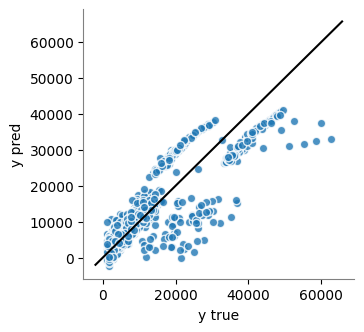

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecasts(y_true, y_pred):
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(y_true, y_pred, color="tab:blue", alpha=0.8, edgecolors="white")
    plt.xlabel("y true")
    plt.ylabel("y pred")
    x_ = np.linspace(*plt.gca().get_xlim())
    plt.gca().plot(x_, x_, "k-")
    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.plot()

plot_forecasts(y_train, y_train_pred)

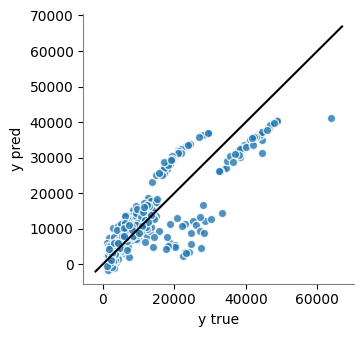

In [ ]:
plot_forecasts(y_test, y_test_pred)

## Análisis independiente

In [ ]:
import seaborn as sns

Para el análisis de variables categóricas sin modificarlas a numéricas.

In [ ]:
!pip install dython

from dython.nominal import associations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

In [ ]:
copia = df.copy()

In [ ]:
copia

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Identificación de variables categóricas

In [ ]:
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(copia)
categorical_features

['sex', 'smoker', 'region']

### Correlaciones

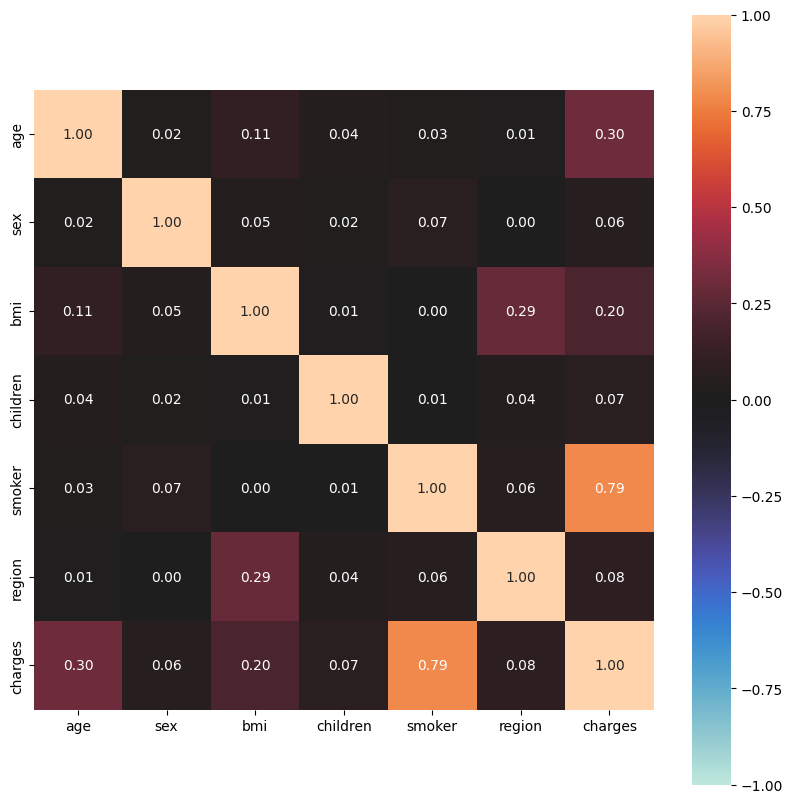

In [ ]:
complete_correlation= associations(copia, filename= 'complete_correlation.png', figsize=(10,10))

Se observa que ser fumador es lo que más impactos tiene en los gastos médicos. Seguido a esto, la edad y el bmi también tienen un impacto menor, pero considerable.

## Recursos de ayuda

https://blog.knoldus.com/how-to-find-correlation-value-of-categorical-variables/